# TSC Mass Assignment

## Background
Triangle-shaped cloud (TSC) mass assignment takes a set of points (optionally with weights) and assigns, or "paints", them onto a mesh.  TSC is a 2nd-order scheme and imparts nice properties to the field and its derivatives.

`abacusutils` contains a parallel TSC implementation under `abacusnbody.analysis.tsc`.  The main entry point is a function called `tsc_parallel()`.

TSC is computationally expensive, because each particle updates a cloud of 27 cells around it, which are mostly not contiguous (or even proximate) in memory.  The bottleneck is thus the memory bandwidth for random writes.  It helps to have multiple CPUs doing this, especially on multi-socket nodes, so parallelization is important.

One can't just assign different threads to different particles, though: if two threads try to update overlapping clouds, that's a race condition.  So the algorithm we use here is to partition the particles along the `x`-dimension into stripes at least as wide as the TSC cloud.  Then we can do all odd-parity stripes at the same time, followed by all even-parity stripes.

In a distributed memory paradigm, like MPI, one *can* parallelize over particles because each rank has a different density grid. But the co-addition of these grids is slow. `nbodykit`, for example, probably uses this approach. The trade-off, of course, is that codes like `nbodykit` can naturally scale to problem sizes that do not fit on a single node. This TSC code is faster, but can't readily scale to multiple nodes.

The thread scaling turns out to be quite good: for a $256^3$ grid with $10^7$ random particles, 1 thread takes 930 ms (10M part/s) and 32 threads takes 20 ms (500M part/s) (2x 32-core Intel Icelake).  This super linear scaling comes from the partitioning, which the serial version doesn't do. So the serial runtime could be improved, but the best partitioning will depend on sortedness of the particles, the grid size, and the CPU cache architecture.  One can experiment with the `npartition` parameter.

The TSC code is tested against `nbodykit`, and it gives the same results. `nbodykit` is substantially slower, though: the single-core performance is 2.1M part/sec on the same hardware, and the 32-core performance is 30M part/s, or 16x slower than this code. But again, `nbodykit` can use multiple nodes and scale to larger problem sizes.

## Basic Usage

In [1]:
import numpy as np

from abacusnbody.analysis.tsc import tsc_parallel

In [2]:
# Generate some particles
N = 10**7
box = 123.
nthread = 32

rng = np.random.default_rng(123)
pos = rng.random((N,3), dtype=np.float32) * box

You can call `tsc_parallel()` with an integer `densgrid=256`, and a $256^3$ grid will be allocated and returned:

In [3]:
ngrid = 256
dens = tsc_parallel(pos, ngrid, box, nthread=nthread)
print(dens.shape)

(256, 256, 256)


Or you can pass a pre-allocated density grid in, in which case the same array that was passed in is returned:

In [4]:
dens = np.zeros((ngrid,ngrid,ngrid), dtype=np.float32)
dens = tsc_parallel(pos, dens, box, nthread=nthread)

The default normalization is that each particle has weight of 1. Likewise, this is a density field, not an overdensity, so all the densities are positive:

In [5]:
print(dens.sum(dtype=np.float64))
print(dens.min())

9999999.963698562
0.0


## Plotting a Cosmological Field

We can load, TSC, and plot a cosmological halo field to check that it looks sane.

In [6]:
import matplotlib.pyplot as plt

from abacusnbody.data.compaso_halo_catalog import CompaSOHaloCatalog

In [7]:
cat = CompaSOHaloCatalog('../../../tests/Mini_N64_L32/halos/z0.000', fields=['x_L2com'])
L = cat.header['BoxSize']

The TSC code will wrap positions to $[0,L)$ internally (with `wrap=True`), but let's do it beforehand so the scatter plot has the same axis limits:

In [8]:
hpos = cat.halos['x_L2com'] % L

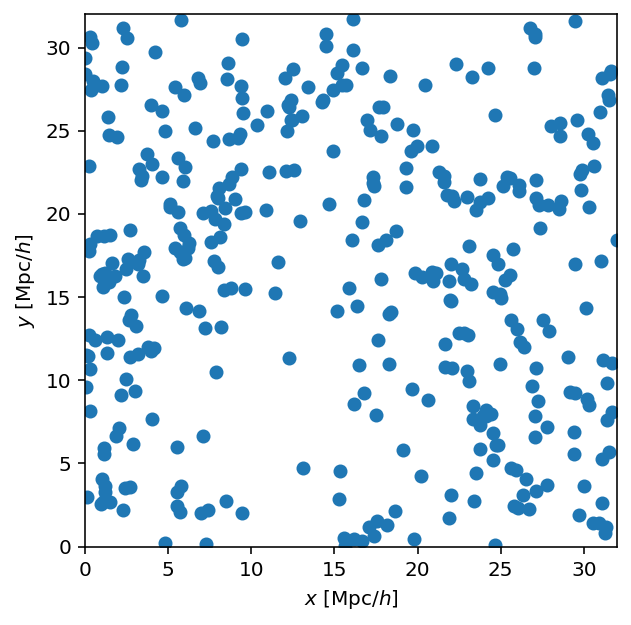

In [9]:
fig, ax = plt.subplots(dpi=144)
ax.set_aspect('equal')
ax.scatter(hpos[:,0], hpos[:,1])
ax.set_xlabel('$x$ [Mpc/$h$]')
ax.set_ylabel('$y$ [Mpc/$h$]')
ax.set_xlim(0, L)
ax.set_ylim(0, L);

/tmp/ipykernel_148372/2118452814.py:1: UserWarning: npartition 32 not large enough to use all 32 threads; should be 2*nthread
  dens = tsc_parallel(hpos, 64, L, nthread=nthread)


Text(0, 0.5, '$y$ [Mpc/$h$]')

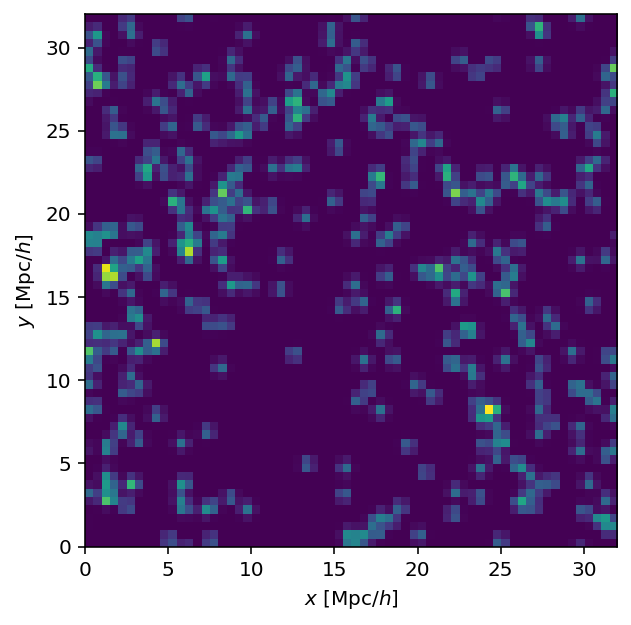

In [10]:
dens = tsc_parallel(hpos, 64, L, nthread=nthread)

fig, ax = plt.subplots(dpi=144)
ax.imshow(dens.sum(axis=2).T,
    origin='lower',
    interpolation='none',
    extent=(0,L,0,L),
    )
ax.set_xlabel('$x$ [Mpc/$h$]')
ax.set_ylabel('$y$ [Mpc/$h$]')

Looks like the same field as the scatter plot; all is well.

## Performance and Precision of `float32` and `float64`

### Performance

Passing the positions and density grid in `float32` precision can be twice as fast as `float64` (and uses half as much memory):

In [11]:
dens = np.zeros((ngrid,ngrid,ngrid), dtype=np.float32)
%timeit tsc_parallel(pos, dens, box, nthread=nthread)

dens64 = np.zeros((ngrid,ngrid,ngrid), dtype=np.float64)
pos64 = pos.astype(np.float64)
%timeit tsc_parallel(pos64, dens64, box, nthread=nthread)

22.6 ms ± 549 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


/mnt/home/lgarrison/abacusutils/abacusnbody/analysis/tsc.py:132: UserWarning: pos.dtype=float64 instead of np.float32. float32 is recommended for performance.
  warnings.warn(f'{name}.dtype={a.dtype} instead of np.float32. '
/mnt/home/lgarrison/abacusutils/abacusnbody/analysis/tsc.py:132: UserWarning: densgrid.dtype=float64 instead of np.float32. float32 is recommended for performance.
  warnings.warn(f'{name}.dtype={a.dtype} instead of np.float32. '
/mnt/home/lgarrison/abacusutils/abacusnbody/analysis/tsc.py:132: UserWarning: pos.dtype=float64 instead of np.float32. float32 is recommended for performance.
  warnings.warn(f'{name}.dtype={a.dtype} instead of np.float32. '
/mnt/home/lgarrison/abacusutils/abacusnbody/analysis/tsc.py:132: UserWarning: densgrid.dtype=float64 instead of np.float32. float32 is recommended for performance.
  warnings.warn(f'{name}.dtype={a.dtype} instead of np.float32. '


47.4 ms ± 812 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Precision

When using `float32`, there are some sources of loss of precision that are good to be aware of.  First, the density field itself may be slightly less accurate due to finite precision in the computation of TSC weights and their co-addition into the density field.  This is usually a small effect in cosmology, since the density fields tend to be sparse.

Second, when taking reductions of the density field (like taking its sum or mean), the sum itself may suffer from loss of precision if it is of the same type width as the field.  This can be a bigger effect for a high number of particles.

Let's look at these effects in two cases:
1) `ngrid=256`, `N=10**7`
1) `ngrid=2048`, `N=5*10**9`

In [12]:
def test_precision(N, ngrid):
    pos = rng.random((N,3), dtype=np.float32) * box
    dens = np.zeros((ngrid,ngrid,ngrid), dtype=np.float32)
    tsc_parallel(pos, dens, box, nthread=nthread)
    print(f'Total dens, 32-bit computation, 32-bit summation type: {dens.sum()}')
    print(f'Total dens, 32-bit computation, 64-bit summation type: {dens.sum(dtype=np.float64)}')

    dens = np.zeros((ngrid,ngrid,ngrid), dtype=np.float64)
    tsc_parallel(pos, dens, box, nthread=nthread)
    print(f'Total dens, 64-bit computation, 64-bit summation type: {dens.sum(dtype=np.float64)}')

print('Case 1:')
test_precision(10**7, 256)
print('Case 2:')
test_precision(5*10**9, 2048)

Case 1:
Total dens, 32-bit computation, 32-bit summation type: 10000000.0
Total dens, 32-bit computation, 64-bit summation type: 9999999.963869026
Total dens, 64-bit computation, 64-bit summation type: 9999999.96737767
Case 2:
Total dens, 32-bit computation, 32-bit summation type: 4991194112.0
Total dens, 32-bit computation, 64-bit summation type: 5000000022.731734


/mnt/home/lgarrison/abacusutils/abacusnbody/analysis/tsc.py:132: UserWarning: densgrid.dtype=float64 instead of np.float32. float32 is recommended for performance.
  warnings.warn(f'{name}.dtype={a.dtype} instead of np.float32. '


Total dens, 64-bit computation, 64-bit summation type: 5000000024.457284


So we see that doing the computation in 32 bits introduces very little error.  The much larger error is the use of a `float32` summation type.

It's good practice to do large reductions using a higher dtype.  So the recommended way to calculate a `float32` overdensity field ($\delta = \rho/\bar\rho - 1$) would be

In [13]:
pos = rng.random((5 * 10**9,3), dtype=np.float32) * box
dens = tsc_parallel(pos, 2048, box, nthread=nthread)

delta = dens / dens.mean(dtype=np.float64) - 1
print(delta.mean(dtype=np.float64))

4.545944613798536e-09


If we hadn't used a `float64` reduction type, we'd be off by 0.2% in the normalization:

In [14]:
deltabad = dens / dens.mean() - 1
print(deltabad.mean(dtype=np.float64))

0.0017726131351884639


The main lessons here are:
1) Prefer to use `float64` for accumulators in summations and other reductions (for accuracy)
1) Prefer to use `float32` for large arrays and particle data (for performance)
1) Test your computation at least once where everything is in `float64` and compare the answer with what you get in `float32`